In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/15859/matrix-factorization

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/15859/matrix-factorization


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
filename = 'data/ml-latest-small/ratings.csv'
df = pd.read_csv(filename)
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
A = np.zeros((193609, 610))
for index, row in df.iterrows():
    A[int(row['movieId']-1), int(row['userId']-1)] = row['rating']
with open('data/A.npy', 'wb') as f:
    np.save(f, A)

In [17]:
with open('data/A.npy', 'rb') as f:
    A = np.load(f)
A = A[~np.all(A == 0, axis=1)]
A.shape

(9724, 610)

In [37]:
def low_rank_best(A, k):
    U, S, VT = np.linalg.svd(A, full_matrices=False)
    X = U[:, :k] @ np.diag(S[:k]) @ VT[:k, :]
    error = np.linalg.norm(A - X) ** 2
    print(error)
    return X, error

In [36]:
def _als_step(ratings, solve_vecs, fixed_vecs):
    A = fixed_vecs.T.dot(fixed_vecs)
    b = ratings.dot(fixed_vecs)
    A_inv = np.linalg.inv(A)
    solve_vecs = b.dot(A_inv)
    return solve_vecs

def alternating_least_square(A, k, num_iters):
    n, d = A.shape
    U = np.random.random((n, k))
    V = np.random.random((d, k))
    error_list = []
    for i in range(num_iters):
        U = _als_step(A, U, V)
        V = _als_step(A.T, V, U)
        error = np.linalg.norm(A - U @ V.T) ** 2
        error_list.append(error)
    return U, V, error_list

In [35]:
def gradient_descent(A, k, num_iters, lr=1e-5, U_init=None, V_init=None):
    n, d = A.shape
    if U_init is None:
        U = np.random.random((n, k))
    else:
        U = U_init
    if V_init is None:
        V = np.random.random((d, k))
    else:
        V = V_init
    error_list = []
    for i in range(num_iters):
        U, V = U + lr * (A - U @ V.T) @ V, V + lr * (A - U @ V.T).T @ U
        error = np.linalg.norm(A - U @ V.T) ** 2
        error_list.append(error)
    return U, V, error_list

In [34]:
def gradient_descent_manifold(A, k, num_iters, lr=1e-5, U_init=None):
    n, d = A.shape
    if U_init is None:
        U = np.random.random((n, k))
        U, _ = np.linalg.qr(U)
    else:
        U = U_init
    error_list = []
    for i in range(num_iters):
        AAU = A @ (A.T @ U)
        grad = -(AAU - U @ (U.T @ AAU))
        U -= lr * grad
        V = A.T @ U
        error = np.linalg.norm(A - U @ V.T) ** 2
        error_list.append(error)
    return U, V, error_list

In [33]:
# Low rank approximation for k=10
def plot_low_rank(k, num_iters):
    _, _, error_list_gd = gradient_descent_manifold(A, k, num_iters, lr=1e-6)
    _, _, error_list_als = alternating_least_square(A, k, num_iters)
    _, best_error = low_rank_best(A, k)
    plt.figure(figsize=(8, 6))
    plt.plot(range(num_iters), [x - best_error for x in error_list_als], label='Alternating Least Squares')
    plt.plot(range(num_iters), [x - best_error for x in error_list_gd], label='Gradient Descent')
    plt.xlabel('Number of Iterations')
    plt.ylabel('$\|A - UV^T\|_F - \|A - A_k\|_F$')
    plt.title(f'$k={k}, \|A - A_k\|_F = {best_error}$')
    plt.legend()
    plt.savefig(f'output/{k}.png')

834691.5219530314
663014.3799196223
376265.1755173408


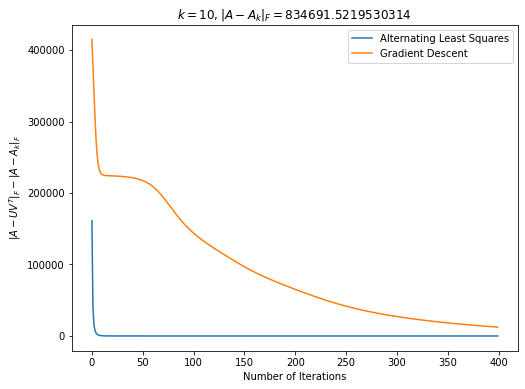

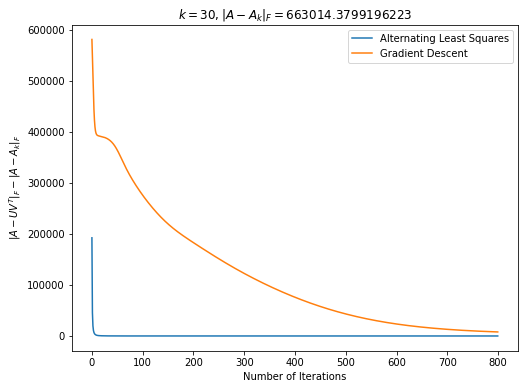

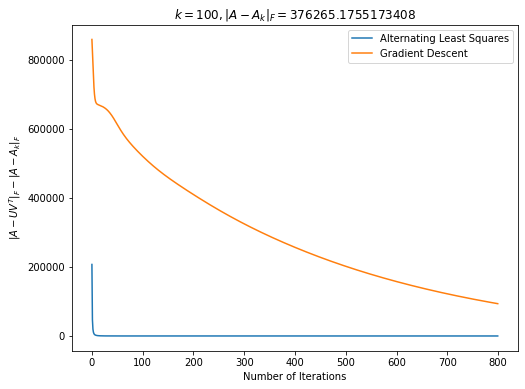

In [39]:
#plot_low_rank(1, 15)
#plot_low_rank(3, 200)
plot_low_rank(10, 400)
plot_low_rank(30, 800)
plot_low_rank(100, 800)